In [1]:
import copy
import time, importlib
import h5py
import pylab as pl, numpy as np, glob, pdb
from numpy import log10 as log
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import os
import pandas as pd
import scipy, scipy.ndimage
import tqdm
import unyt

In [2]:
import matplotlib.gridspec as gridspec

In [3]:
import palettable

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [5]:
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

In [6]:
import coolingFunction

In [7]:
%matplotlib inline

# Parameters

In [8]:
# Sim params
sim_name = 'm12i_md'
snum = 600
resolution = 7100
physics = 'metal_diffusion'
subsubdir = None

In [9]:
# Tracking data params
tag = 'hothaloacc'
galdef = ''
ahf_index = 600

In [10]:
# Data locations
fig_dir = '../figures/'
tables_dir = '/work/03057/zhafen/CoolingTables/'

In [11]:
# Constants
mu = 0.62
X = 0.7
gamma = 5/3

In [12]:
# Time analysis parameters

# so there are at least 20 snapshots after accretion, not including last 10 snapshots with small
minInd = 30
# t_1e5 bins in Gyr
t1e5_width = 0.5

# Load Data

In [13]:
fm = file_management.FileManager( 'hot_halo_physics' )

In [14]:
linefinder_dir = fm.get_linefinder_dir(
    sim_name = sim_name,
    resolution = resolution,
    physics = physics,
    subsubdir = subsubdir
)

In [15]:
halo_data_dir = fm.get_halo_dir(
    sim_name = sim_name,
    resolution = resolution,
    physics = physics,
    subsubdir = None,
    halo_subdir = '',
)

In [16]:
full_tag = '{}_{}'.format( sim_name, tag )

In [17]:
w = a_worldlines.Worldlines(
    data_dir = linefinder_dir,
    tag = full_tag,
    galdef = galdef,
    ahf_index = ahf_index,
    halo_data_dir = halo_data_dir,
)

In [18]:
print( w.tag )

m12i_md_hothaloacc


In [19]:
ind = ahf_index - snum

# Analyze

### Find $t_{10^5 K}$

In [20]:
# Identify indices where temperature is first above 1e5 K
# This method is equivalent to Jonathan's commented out method above, but without needing to manually handle edge cases,
# at the cost of being slightly slower

logT = log( w.get_data( 'T' ) )
inds = []
for logT_arr in tqdm.tqdm( logT ):

    ind_ = 0
    for i in range( logT_arr.size ):
        if logT_arr[i] > 5.:
            ind_ = i
            break

    inds.append( ind_ )

inds = np.array( inds )

100%|██████████| 45846/45846 [00:02<00:00, 20355.91it/s]


(-50, 100)

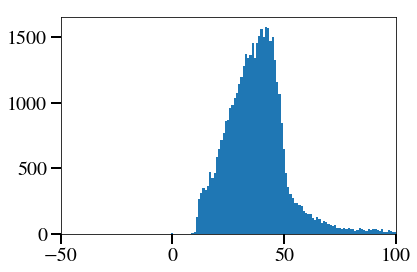

In [21]:
pl.hist(inds,bins=np.arange(-30.5,601))
pl.xlim(-50,100)

In [22]:
# Get t_1e5K
age = w.get_data( 'time' )
t1e5 = age[inds]

(12.804038047790527, 13.804038)

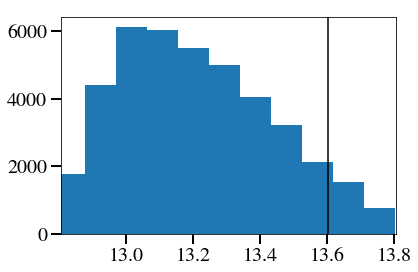

In [23]:
fig = plt.Figure()
ax = plt.gca()

ax.hist(t1e5,bins=128)
ax.axvline( np.nanpercentile( t1e5, 5 ), color='k' )
ax.axvline( np.nanpercentile( t1e5, 100. - 5), color='k' )

ax.set_xlim(age[0] - 1,t1e5.max())


### Get Angular Momentum

In [24]:
jmag_raw = w.get_data( 'Lmag' ) / w.get_data('M') * ( unyt.kpc * unyt.km / unyt.s )

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [25]:
tot_mom_fp = os.path.join( w.data_dir, 'tot_momentums.hdf5' )
tot_moms = h5py.File( tot_mom_fp, 'r' )
tot_mom = tot_moms[sim_name]['snum{}'.format( snum )][...]
tot_mom_normed = tot_mom / np.linalg.norm( tot_mom )

In [26]:
j_raw = w.get_data( 'L' ) / w.get_data('M') * ( unyt.kpc * unyt.km / unyt.s )

In [27]:
jz_raw = np.array([ np.dot( j_raw[:,:,i].transpose(), tot_mom_normed ) for i in range( w.snums.size ) ]).transpose()

In [28]:
# This can take a while because we need to open all the different profiles (one per snapshot).
rvc_raw = []
for snum in tqdm.tqdm( w.snums ):
    rs = w.get_data( 'R' )[:,w.snums[0]-snum]
    try:
        rvc_i = w.halo_data.get_profile_data( 'vcirc', snum, rs ) * rs
    except ( KeyError, TypeError ) as e:
        rvc_i = np.full( rs.shape, np.nan )
    rvc_raw.append( rvc_i )

100%|██████████| 600/600 [05:57<00:00,  5.99it/s]


In [29]:
rvc_raw = np.array( rvc_raw )
rvc_raw = rvc_raw.transpose()

### Center on $t_{10^5 K}$

In [30]:
def roll_by_inds(arr, inds):
    rows, cols = np.ogrid[:arr.shape[0],:arr.shape[1]]
    cols = (cols + inds[:,np.newaxis])%arr.shape[1]
    return arr[rows,cols]

In [31]:
# We'll make a dictionary for rolled data
rolled = {}
keys_to_roll = [
    ( 'Den', unyt.cm**-3 ),
    ( 'T', unyt.K ),
    ( 'Z', unyt.Zsun ),
    ( 'M', unyt.Msun ),
    ( 'R', unyt.kpc ),
]
for i, ( key, unit ) in enumerate( keys_to_roll ):
    print( key )
    rolled[key] = roll_by_inds( w.get_data( key ), inds )[inds>minInd] * unit

Den
T
Z
M
R


In [32]:
t_unrolled = w.get_selected_data( 'time', tile_data=True )
t = roll_by_inds( t_unrolled, inds )[inds>minInd]

In [33]:
jmag = roll_by_inds( jmag_raw, inds )[inds>minInd]
rvc = roll_by_inds( rvc_raw, inds )[inds>minInd]
jz = roll_by_inds( jz_raw, inds )[inds>minInd]
t1e5 = t1e5[inds>minInd]

In [34]:
j_rolled = np.array([ roll_by_inds( _, inds )[inds>minInd] for _ in j_raw ])

In [35]:
dt0 = ( np.median( np.gradient( t_unrolled, axis=1)[0,:100 ] ) * unyt.Gyr ).to( 'Myr' )
dnHdt_unrolled = np.gradient( w.get_data( 'Den' )*unyt.cm**-3, axis=1 ) / dt0
dnHdt = roll_by_inds( dnHdt_unrolled[:,:], inds )[inds>minInd]

### Calculate Cooling and Compression

In [36]:
# R = w.get_data( 'R' )
nH = rolled['Den']
T = rolled['T']
r = rolled['R']
K = ( T/nH**(2/3.) * unyt.kb ).to('keV*cm**2')
P = ( (mu * X)**-1 * nH * unyt.kb ).to( 'erg/K/cm**3' )* T
rho = nH * unyt.mp / X
# V = np.float64(rolled['M']) / rho * un.Msun.to('g')

In [37]:
LAMBDA = coolingFunction.LambdaFunc(0, tables_dir, 0.2485)(
    rolled['T'].value,
    rolled['Den'].value,
    rolled['Z'].value,
) * unyt.erg * unyt.cm**3 / unyt.s #using z=0 is an approximation
rad_per_unit_volume = nH**2*LAMBDA 
rad_per_unit_mass = ( rad_per_unit_volume / rho ).to( 'erg/s/g' )
rad = rad_per_unit_mass * rolled['M']

In [38]:
compress_per_unit_volume = ( P*dnHdt / nH ).to( 'erg/s/cm**3' )
compress_per_unit_mass = ( compress_per_unit_volume  / rho ).to( 'erg/s/g' )

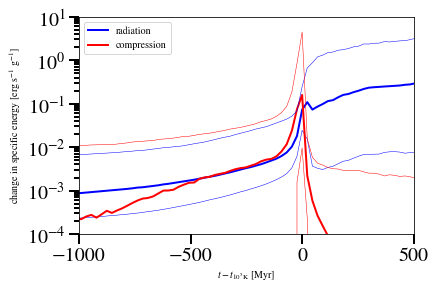

In [39]:
inds2 = np.arange(-50,100)
pl.figure()
ax=pl.subplot(111)
for ip,p in enumerate((16,50,84)):
    pl.plot(inds2*dt0, np.nanpercentile(rad_per_unit_mass,p,axis=0)[inds2],
            c='b',lw=(0.5,2)[ip==1],label=('_',r'radiation')[ip==1])
    pl.plot(inds2*dt0, np.nanpercentile(compress_per_unit_mass,p,axis=0)[inds2],
            c='r',lw=(0.5,2)[ip==1],
           label=('_',r'compression')[ip==1])
ax.set_yscale('log')
pl.xlim(-1000,500)
pl.ylim(1e-4,10) 
pl.ylabel(r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]')
pl.xlabel(r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$')
pl.legend()
# pl.savefig(figDir+'rad_vs_compress.png')

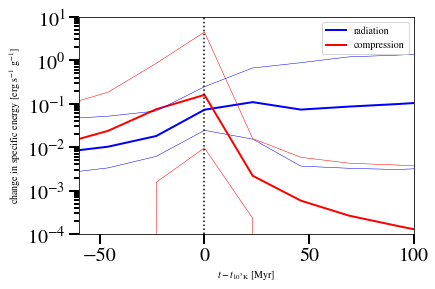

In [40]:
inds2 = np.arange(-50,100)
pl.figure()
ax=pl.subplot(111)
for ip,p in enumerate((16,50,84)):
    pl.plot(inds2*dt0, np.nanpercentile(rad_per_unit_mass,p,axis=0)[inds2],
            c='b',lw=(0.5,2)[ip==1],label=('_',r'radiation')[ip==1])
    pl.plot(inds2*dt0, np.nanpercentile(compress_per_unit_mass,p,axis=0)[inds2],
            c='r',lw=(0.5,2)[ip==1],
           label=('_',r'compression')[ip==1])
ax.set_yscale('log')
pl.xlim(-60,100)
pl.ylim(1e-4,10) 
pl.ylabel(r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]')
pl.xlabel(r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$')
pl.legend()
pl.axvline(0,c='k',ls=':')
# pl.savefig(figDir+'rad_vs_compress_zoom.png')

### Bin into bins of $t_{10^5 K}$ with fixed width and sum heating and cooling

In [41]:
t1e5_width = 0.1

In [42]:
# Bins. Note that we offset by the width of the last snapshot to avoid the most obvious edge cases
t1e5_bins = np.arange( age.max() + 0.5*(age[0] - age[1]), 11., -t1e5_width )

In [43]:
time = inds2*dt0

In [44]:
# This is essential. If not removing outliers we get very weird results when calculating the mean.
def remove_outliers( a, q=99 ):
    outlier = np.nanpercentile( np.abs( a ), q )
    result = copy.copy( a )
    result[np.abs(a)>outlier] = outlier
    
    return result

In [45]:
binned_rad_per_unit_mass = []
binned_compress_per_unit_mass = []
mean_j = []
mean_rad_per_unit_mass = []
mean_compress_per_unit_mass = []
for i, start in enumerate( t1e5_bins[:-1] ):
    
    end = t1e5_bins[i+1]
    in_bin = ( t1e5 < start ) & ( t1e5 > end )
    
    binned_rad_per_unit_mass.append( rad_per_unit_mass[in_bin] )
    binned_compress_per_unit_mass.append( compress_per_unit_mass[in_bin] )
    
    # Don't try to sum t1e5 bins with too few particles
    if in_bin.sum() < t1e5.size * 0.05:
        mean_rad_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_compress_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_j.append( np.full( (3, 600,), np.nan ) )
        continue
        
    # Avoid edge cases affecting the results
    rad = remove_outliers( rad_per_unit_mass[in_bin] )
    compress = remove_outliers( compress_per_unit_mass[in_bin] )
    
    mean_j_i =  np.array([ np.nanmean( _[in_bin], axis=0 ) for _ in j_rolled ])
        
    mean_rad_per_unit_mass.append( np.nanmean( rad, axis=0 ) )
    mean_compress_per_unit_mass.append( np.nanmean( compress, axis=0 ) )
    mean_j.append( mean_j_i )

In [46]:
mean_jz = np.array([ np.dot( _.transpose(), tot_mom_normed ) for _ in mean_j ])
mean_jmag = np.array([ np.linalg.norm( _, axis=0 ) for _ in mean_j ])
mean_jz_jmag = mean_jz / mean_jmag

In [47]:
mean_j_all = np.array([ np.nanmean( _, axis=0 ) for _ in j_rolled ])
mean_jz_all = np.dot( mean_j_all.transpose(), tot_mom_normed )

In [48]:
total_j = np.array([ np.nansum( _, axis=0 ) for _ in j_rolled ])
total_jz = np.dot( total_j.transpose(), tot_mom_normed )
total_jmag = np.linalg.norm( total_j, axis=0 )
total_jz_jmag = total_jz / total_jmag
circulation = total_jmag / np.nansum( jmag, axis=0 )

In [49]:
n_bin = np.array([ _.shape[0] for _ in binned_rad_per_unit_mass ])

Text(0.5, 0, '$t - t_{10^5{\\rm K}}\\ [{\\rm Myr}]$')

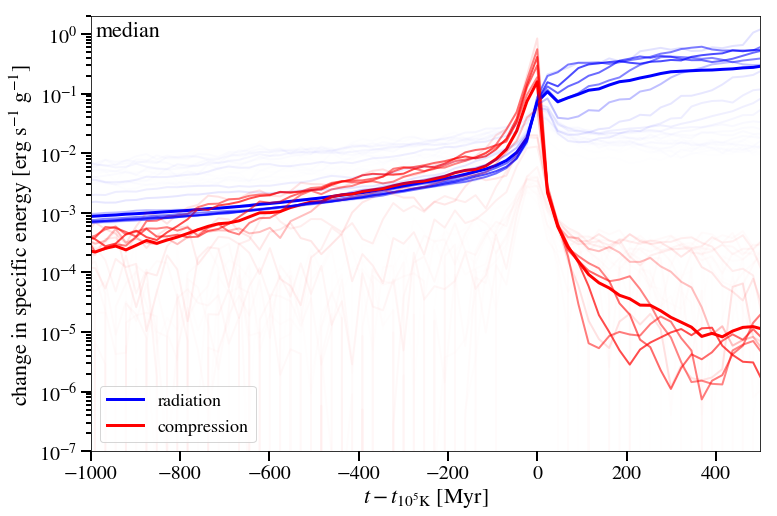

In [50]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

# Total median
ax.plot(
    time,
    np.nanmedian( rad_per_unit_mass, axis=0 )[inds2],
    color = 'b',
    linewidth = 3,
    label = 'radiation',
)
ax.plot(
    time,
    np.nanmedian( compress_per_unit_mass, axis=0 )[inds2],
    color = 'r',
    linewidth = 3,
    label = 'compression',
)

# In bins
for i, rad in enumerate( binned_rad_per_unit_mass ):
    ax.plot(
        time,
        np.nanmedian( rad, axis=0 )[inds2],
        color = 'b',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    ax.plot(
        time,
        np.nanmedian( binned_compress_per_unit_mass[i], axis=0 )[inds2],
        color = 'r',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    
ax.annotate(
    s = 'median',
    xy = ( 0, 1 ),
    xytext = ( 5, -5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    va = 'top',
    ha = 'left',
)

ax.set_yscale( 'log' )
ax.set_xlim( -1000, 500 )
ax.set_ylim( 1e-7, 2 )
ax.legend( prop={'size': 18}, loc='lower left', )

ax.set_ylabel( r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]', fontsize=22 )
ax.set_xlabel( r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$', fontsize=22 )

# pl.savefig( figDir+'rad_vs_compress_median.pdf' )

## Summary Figure

In [51]:
colormap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

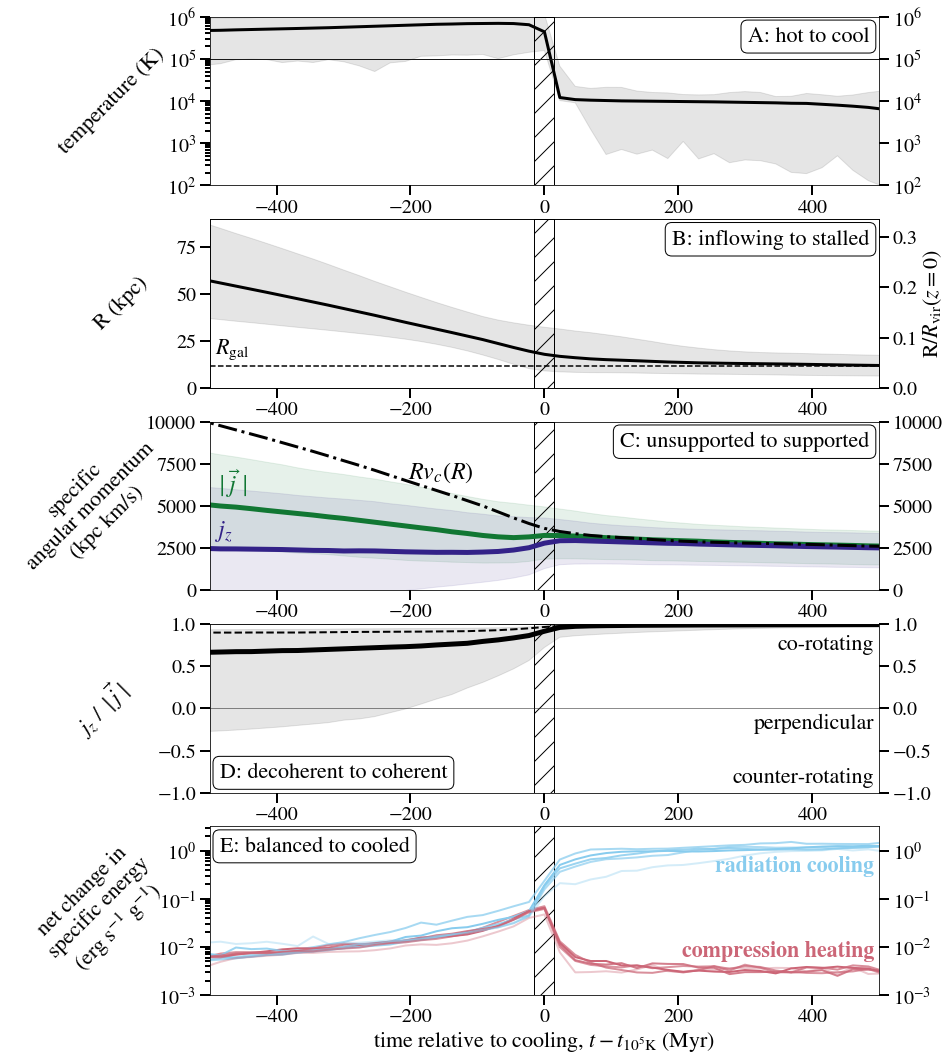

In [52]:
fig = plt.figure( figsize=(12,18), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=1, nrows=5, )

errt = 30./2.

### T ##########

ax = fig.add_subplot( gs[0,:] )

ax.annotate(
    s = r'A: hot to cool',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot T
T_med = np.nanpercentile( rolled['T'], 50., axis=0 )
ax.plot(
    time,
    T_med[inds2],
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( rolled['T'][inds2], 16, axis=0 )[inds2],
    np.nanpercentile( rolled['T'][inds2], 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.axhline(
    1e5,
    color = '0.1',
    linewidth = 1,
)
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 1e2, 1e6 )
ax.set_ylabel(
    'temperature (K)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )

### R #############

ax = fig.add_subplot( gs[1,:] )

ax.annotate(
    s = r'B: inflowing to stalled',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

r_med = np.nanpercentile( r, 50., axis=0 )
ax.plot(
    time,
    r_med[inds2],
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( r, 16, axis=0 )[inds2],
    np.nanpercentile( r, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     s = r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = 'k',
    linestyle = '--',
)
ax.annotate(
#     s = r'$4 R_\star(z=0)$',
    s = r'$R_{\rm gal}$',
#     s = 'disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'bottom',
    color = 'k',
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 90 )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'R (kpc)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'R/$R_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )

### Total Angular Momentum ################

ax = fig.add_subplot( gs[2,:] )

ax.annotate(
    s = r'C: unsupported to supported',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Total angular momentum
j_med = np.nanpercentile( jmag, 50., axis=0 )
ax.plot(
    time,
    j_med[inds2],
    color = colormap[3],
#     color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jmag, 16, axis=0 )[inds2],
    np.nanpercentile( jmag, 84., axis=0 )[inds2],
    color = colormap[3],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med[inds2] )( -500 )
ax.annotate(
    s = r'$\mid \vec j \mid$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)

# z-component angular momentum
j_med = np.nanpercentile( jz, 50., axis=0 )
ax.plot(
    time,
    j_med[inds2],
    color = colormap[4],
#     color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jz, 16, axis=0 )[inds2],
    np.nanpercentile( jz, 84., axis=0 )[inds2],
    color = colormap[4],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med[inds2] )( -500 )
ax.annotate(
    s = r'$j_z$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
#     color = 'k',
    fontweight = 'bold',
)

# Rvc
rvc_med = np.nanpercentile( rvc, 50., axis=0 )
ax.plot(
    time,
    rvc_med[inds2],
#     color = colormap[4],
    color = 'k',
    linewidth = 3,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( rvc, 84., axis=0 )[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, rvc_med[inds2] )( -200 )
ax.annotate(
    s = r'$Rv_c(R)$',
    xy = ( -200, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
#     color = colormap[4],
    color = 'k',
    fontweight = 'bold',
)

# # Alternative that's the ratio
# j_med = np.nanpercentile( jmag / rvc, 50., axis=0 )
# ax.plot(
#     time,
#     j_med[inds2],
#     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( jmag / rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( jmag / rvc, 84., axis=0 )[inds2],
#     color = 'k',
#     alpha = 0.1,
# )
# ax.axhline(
#     1.,
#     color = 'k',
#     linestyle = '--',
# )

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# ax.axhline(
#     j_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.annotate(
#     s = r'$j(t=t_{10^5{\rm K}})$',
#     xy = ( -200, j_med[0] ),
# #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'right',
#     va = 'top',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 1e4 )
# ax.set_ylim( 0, 1. )
ax.set_ylabel(
    'specific\nangular momentum\n(kpc km/s)',
#     r'$\mid \vec j \mid / (\, Rv_c(R)\, )$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.tick_params( right=True, labelright=True, )


### Circularity #################

ax = fig.add_subplot( gs[3,:] )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
ax.annotate(
    s = r'D: decoherent to coherent',
    xy = ( 0, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)
c = jz / jmag
c_med = np.nanpercentile( c, 50., axis=0 )
ax.plot(
    time,
    c_med[inds2],
#     total_jz_jmag[inds2],
    color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( c, 16, axis=0 )[inds2],
    np.nanpercentile( c, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)
# y_annot = scipy.interpolate.interp1d( time, c_med[inds2] )( -500 )
# ax.annotate(
#     s = r'median',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
# y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
# ax.annotate(
#     s = r'$L_z$ / $\mid \vec L \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -2.5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )

ax.axhline(
    1,
    color = '0.1',
    linewidth = 0.5,
)
ax.annotate(
    s = 'co-rotating',
    xy = ( 1, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)
ax.axhline(
    0,
    color = '0.1',
    linewidth = 0.5,
)
ax.annotate(
    s = 'perpendicular',
    xy = ( 1, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
)
ax.annotate(
    s = 'counter-rotating',
    xy = ( 1, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.tick_params( right=True, labelright=True, )

### Energy ###########

ax = fig.add_subplot( gs[4,:] )

ax.annotate(
    s = r'E: balanced to cooled',
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for i, rad in enumerate( mean_rad_per_unit_mass ):
    
#     # Don't look at edge cases from early on
#     if t1e5_bins[i] < 12:
#         continue
    
    ax.plot(
        time,
        rad[inds2],
        color = colormap[0],
        alpha = n_bin[i]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[i][inds2],
        color = colormap[1],
        alpha = n_bin[i]/n_bin.max(),
        linewidth = 2,
    )

# ax.plot(
#     time,
#     np.nanmean( rad_per_unit_mass, axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     linestyle = '--',
# )
# ax.plot(
#     time,
#     np.nanmean( compress_per_unit_mass, axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     linestyle = '--',
# )
# Total mean
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     label = 'radiation',
# )
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( compress_per_unit_mass ), axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     label = 'compression',
# )

ax.annotate(
    s = 'radiation cooling',
    xy = ( 1, 1. ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = colormap[0],
    fontweight = 'bold',
)
ax.annotate(
    s = 'compression heating',
    xy = ( 1, 4e-3 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = colormap[1],
    fontweight = 'bold',
)

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)
    
# ax.annotate(
#     s = 'mean',
#     xy = ( 0, 1 ),
#     xytext = ( 5, -5 ),
#     xycoords = 'axes fraction',
#     textcoords = 'offset points',
#     fontsize = 22,
#     va = 'top',
#     ha = 'left',
# )

ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
ax.set_ylim( 1e-3, 10**0.5 )
# ax.legend( prop={'size': 18}, loc='lower left', )
ax.tick_params( right=True, labelright=True, )

ax.set_ylabel(
    'net change in\nspecific energy\n' + r'(${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$)',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = 55.0,
)
ax.set_xlabel( r'time relative to cooling, $t - t_{10^5{\rm K}}\ ({\rm Myr})$', fontsize=22 )

pl.savefig( fig_dir+'before_vs_after.pdf', bbox_inches='tight' )

In [53]:
c_med_fn = scipy.interpolate.interp1d( time, c_med[inds2] )

In [54]:
c_med_fn( -500 )

array(0.66502327)

In [55]:
c_med_fn( -errt )

array(0.8810929)

Things of note:
* I removed outliers. (Dashed is what happens when I don't yeet contributions from the 99th percentile of absolute specific energy.)
* Alpha scales with n_bin

### Additional Technical Plots

In [56]:
def e_per_m_hist( ax, e_per_m ):
    bins = np.logspace( -5, np.log10( np.nanmax( np.abs( e_per_m ) ) ), 32 )

    ax.hist(
        np.abs( e_per_m ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
    )
    ax.hist(
        np.abs( e_per_m[e_per_m<0] ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        linestyle = ':',
        label = 'negative',
    )
    ax.hist(
        np.abs( e_per_m[e_per_m>0] ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        linestyle = '--',
        label = 'positive',
    )

    ax.axvline(
        np.nanmedian( e_per_m ),
        linewidth = 3,
    )
    ax.axvline(
        np.nanmean( remove_outliers( e_per_m ) ),
        linewidth = 3,
        linestyle = '--',
    )
    ax.annotate(
        s = 'median = {:.2g}\nmean={:.2g}'.format( np.nanmedian( e_per_m ), np.nanmean( e_per_m ) ),
        xy = ( 0, 1 ),
        xytext = ( 5, -5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 18,
        va = 'top',
        ha = 'left',
    )

    ax.set_xscale( 'log' )

    ax.legend( prop={'size': 18} )


Text(0.5, 0, 'Magnitude of Change in Radiation Specific Energy')

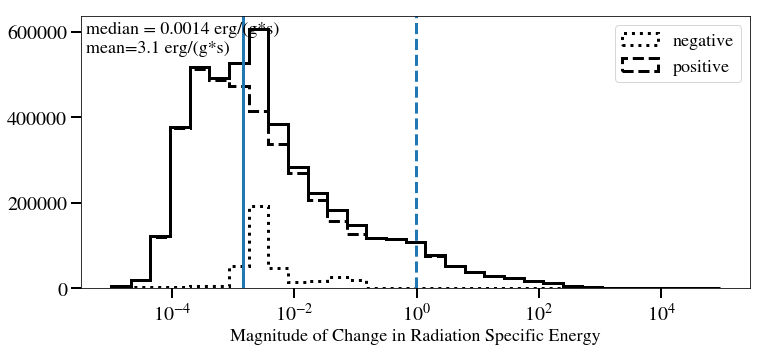

In [57]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

e_per_m_hist( ax, rad_per_unit_mass[:,inds2].flatten(),)

ax.set_xlabel( 'Magnitude of Change in Radiation Specific Energy', fontsize=18 )

Text(0.5, 0, 'Magnitude of Change in Compression Specific Energy')

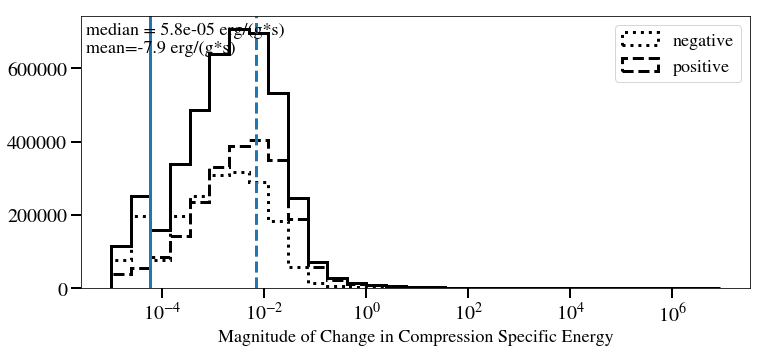

In [58]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

e_per_m_hist( ax, compress_per_unit_mass[:,inds2].flatten(),)

ax.set_xlabel( 'Magnitude of Change in Compression Specific Energy', fontsize=18 )